In [78]:
import numpy as np
import plotly as plty
import pandas as pd 
from scipy.stats import norm
import yfinance as y
import matplotlib.pyplot as plt

In [79]:
class option:
    def __init__(self,Spot,Strike,vol,Time,rates,Dividend_yield):
        self.S=Spot
        self.K=Strike
        self.v=vol
        self.T=Time
        self.r=rates
        self.q=Dividend_yield
        if np.any(Spot<0) or vol<0 or Time<=0:
            raise ValueError('The values are not following the assumptions of the model ')




    def summary(self):
        print(f'you are pricing an option with parameters: S={self.S}, K={self.K}, vol={self.v}, T={self.T}, r={self.r}, q={self.q}')


class European_option(option):
    @property
    def d1(self):
        return (np.log(self.S/self.K)+(self.r-self.q+0.5*(self.v**2))*self.T)/(self.v*np.sqrt(self.T))
    
    @property
    def d2(self):
        return self.d1-self.v*np.sqrt(self.T)

        

    def Call(self):
        return self.S*np.exp(-self.q*self.T)*norm.cdf(self.d1,0,1)-self.K*np.exp(-self.r*self.T)*norm.cdf(self.d2,0,1)
    
    def Put(self):
        return -self.S*np.exp(-self.q*self.T)*norm.cdf(-self.d1,0,1)+self.K*np.exp(-self.r*self.T)*norm.cdf(-self.d2,0,1)
    
    def parity(self):
        C=self.Call()
        P=self.Put()
        if C+self.K*np.exp(-self.r*self.T)!= P+self.S*np.exp(-self.d*self.T):
            return("Arbitrage opportunity the call/put parity is not respected ")
        else:
            return("No arbitrage opportunity, the call/put parity is respected")

    
    def Delta(self,option_type):

        if str(option_type.capitalize())=='Call':
            return norm.cdf(self.d1,0,1)*np.exp(-self.q*self.T)
        
        elif str(option_type.capitalize())=='Put':
            return -norm.cdf(-self.d1,0,1)*np.exp(-self.q*self.T)
        
        else:
            raise ValueError('please select Call or Put')


    def delta_graph(self,start,end,option_type):

        intitial_price=self.S
        self.S=np.linspace(max(0.1,start),end,1000)
        plt.figure()
        plt.plot(self.S,self.Delta(str(option_type.capitalize())))
        plt.title('Evolution of Delta')
        plt.xlabel('Underlying asset price')
        plt.ylabel('Delta')
        plt.grid(True)
        self.S=intitial_price
        
    
    def Gamma(self):
        return (norm.pdf(self.d1,0,1)/(self.S*np.sqrt(self.T)*self.v))*np.exp(-self.d*self.T)
    

    def gamma_graph(self,start,end):

        intitial_price=self.S
        self.S=np.linspace(max(0.01,start),end,1000)
        plt.figure()
        plt.plot(self.S,self.Gamma())
        plt.title('Evolution of Gamma')
        plt.xlabel('Underlying asset price')
        plt.ylabel('Gamma')
        plt.grid(True)
        self.S=intitial_price
    

    def Vega(self):
        return self.S*np.exp(-self.q*self.T)*norm.pdf(self.d1,0,1)*np.sqrt(self.T)/100
    
    def vega_graph(self):
        initial_price=self.S
        self.S=np.linspace(0,self.S*3,300)
        plt.figure()
        plt.plot(self.S,self.Vega())
        plt.title('Evolution of Vega')
        plt.xlabel('Underlying asset price')
        plt.ylabel('Vega')
        plt.grid(True)
        self.S=initial_price


    def Theta(self,option_type):

        if str(option_type.capitalize())=='Call':
            return(-((self.S*np.exp(-self.q*self.T)*norm.pdf(self.d1,0,1)*self.v)/(2*np.sqrt(self.T)))+self.q*self.S*np.exp(-self.q*self.T)* norm.cdf(self.d1, 0, 1)-self.r*self.K*np.exp(-self.r*self.T)*norm.cdf(self.d2,0,1))/252
        
        elif str(option_type.capitalize())=='Put':
            return(-((self.S*np.exp(-self.q*self.T)*norm.pdf(self.d1,0,1)*self.v)/(2*np.sqrt(self.T)))-self.q*self.S*np.exp(-self.q*self.T)* norm.cdf(-self.d1, 0, 1)+self.r*self.K*np.exp(-self.r*self.T)*norm.cdf(-self.d2,0,1))/252
        
        else:
            raise ValueError('please select Call or Put')
        
    def theta_graph(self, end, option_type):
        intitial_price=self.S
        self.S=np.linspace(0,int(end),300)
        plt.figure()
        plt.plot(self.S,self.Theta(option_type.capitalize()))
        plt.title('Evolution of Theta')
        plt.xlabel('Underlying asset price')
        plt.ylabel('Theta')
        plt.grid(True)
        self.S=intitial_price


    def Rho(self, option_type):
        
        if str(option_type.capitalize())=='Call':
            return (self.K*self.T*np.exp(-self.r*self.T)*norm.cdf(self.d2,0,1))/100
        
        elif str(option_type.capitalize())=='Put':
            return (-self.K*self.T*np.exp(-self.r*self.T)*norm.cdf(-self.d2,0,1))/100
        
        else:
            raise ValueError('please select Call or Put')
        
    def rho_graph(self, option_type):
        intitial_price=self.S
        self.S=np.linspace(0,intitial_price*2,300)
        plt.figure()
        plt.plot(self.S,self.Rho(option_type.capitalize()))
        plt.title('Evolution of Rho')
        plt.xlabel('Underlying asset price')
        plt.ylabel('Rho')
        plt.grid(True)
        self.S=intitial_price



class American_option(option):
    def American_option_price(self,N,option_type):


        t=self.T/N
        u=np.exp(self.v*np.sqrt(t))
        d=1/u
        p=(np.exp((self.r-self.q)*t)-d)/(u-d)


        B=np.zeros(shape=[N+1,N+1])

        B[0,0]=self.S

        for i in range (N+1):
            for j in range(i+1):
                B[j,i]=self.S*(u**(i-j))*(d**(j))
        C=np.zeros(shape=[N+1,N+1])

        if option_type.capitalize() == 'Call':
            C[:, N] = np.maximum(B[:, N] - self.K, 0)
        elif option_type.capitalize() == 'Put':
            C[:, N] = np.maximum(self.K - B[:, N], 0)
        else:
            raise ValueError('Please select Call or Put')


        for i in range(N - 1, -1, -1):
            for j in range(i + 1):

                hold_value = np.exp(-self.r * t) * (p * C[j, i + 1] + (1 - p) * C[j + 1, i + 1])
            
            

                if option_type.capitalize() == 'Call':
                    exercise_value = max(B[j, i] - self.K, 0)
                else:
                    exercise_value = max(self.K - B[j, i], 0)
                C[j, i] = max(hold_value, exercise_value)
            
    
        return C[0,0]


/var/folders/_n/wtyyv5nn2rl75vgbry80x49h0000gn/T/ipykernel_9935/4036622527.py:22: RuntimeWarning:

divide by zero encountered in log



np.float64(9.226357565044532)

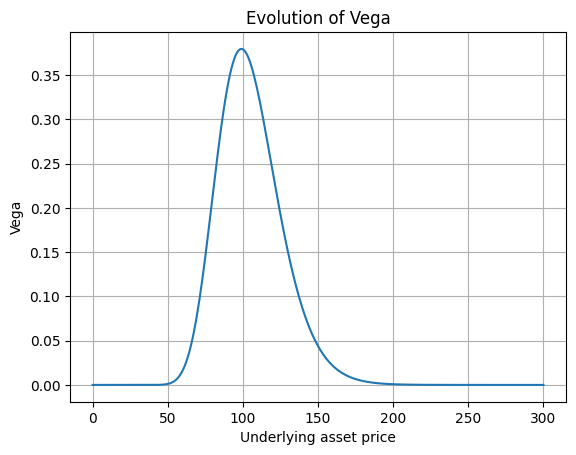

In [80]:
option1=European_option(100,100,0.2,1,0.05,0.02)
option1.vega_graph()

option2=American_option(100,100,0.2,1,0.05,0.02)
option2.American_option_price(3000,'call')